<a href="https://colab.research.google.com/github/ThesanR/TorontoPermitClassification/blob/main/PermitClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Importing datasets directly from the City of Toronto Open data site.

#2015 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/fbceeefc-a24d-43d0-8009-a1ec872550d0/download/Cleared%20Permits%202015.zip
!unzip -q "Cleared Permits 2015.zip"
#2016 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/b6f1907e-5a45-43f7-8c3c-56e4edc4f42f/download/Cleared%20Permits%202016.zip
!unzip -q "Cleared Permits 2016.zip"
#2017-2023 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/23de66da-ed1a-434a-a0fa-d85ec55f8f20/download/Cleared%20Building%20Permits%20since%202017.csv
#Active Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/108c2bd1-6945-46f6-af92-02f5658ee7f7/resource/dfce3b7b-4f17-4a9d-9155-5e390a5ffa97/download/building-permits-active-permits.csv

Classification of Permit applications from the City of Toronto between the years 2000 and 2023.

In [23]:
# 2. Importing relevant libraries to analyze data.
import pandas as pd
import numpy as np

# 3. Setting variables for imported CSV files. Seting POSTAL column to string and Revision number to str to reduce computation file due to improper source file formatting.
df2015 = pd.read_csv('clearedpermits2015.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2016 = pd.read_csv('clearedpermits2016.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2017_2023 = pd.read_csv('Cleared Building Permits since 2017.csv', dtype={"POSTAL": str, "REVISION_NUM": str})

# 4. Concatenating CSV files into one dataframe.
df = pd.concat([df2015, df2016, df2017_2023], ignore_index=True, sort=False)

# 5. Dropping rows that have bad data such as empty postal codes, permit statuses that are not closed, estimated construction costs that are not numbers, null values.
#    Updating dataframe to have 8 columns for proposed features and target vector (To be constructed based on transformed data from the application data and issued date columns).
df = df.drop(df[(df.POSTAL == "   ") | (df.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD") | (df.STATUS != "Closed")].index)
df = df[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'POSTAL', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
df = df.dropna()

# 6. Formatting estimated construction cost column to be only integers by purging commas and rows with values less than $100.
dftemp = ((df['EST_CONST_COST'].replace(",","", regex=True)).astype(float)).astype(int)
df = df.drop('EST_CONST_COST', axis=1)
df = pd.concat([df, dftemp], axis=1)
df = df.drop(df[df.EST_CONST_COST < 100].index)

# 7. Getting value counts from permit type, work, and structure type. Removing value counts less than a particular threshold to have a small set of highly populated types rather than a large set of varied data.
df = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]
df = df[~df['WORK'].isin((df['WORK'].value_counts())[(df['WORK'].value_counts()) < 1000].index)]
df = df[~df['STRUCTURE_TYPE'].isin((df['STRUCTURE_TYPE'].value_counts())[(df['STRUCTURE_TYPE'].value_counts()) < 500].index)]
# 7a. Removing duplicate permit numbers.
df = df[~df['PERMIT_NUM'].isin((df['PERMIT_NUM'].value_counts())[(df['PERMIT_NUM'].value_counts()) > 1].index)]

# 7b. Viewing value counts.
#print(df.PERMIT_NUM.value_counts(), "\n")
#print(df.POSTAL.value_counts(), "\n")
#print(df.PERMIT_TYPE.value_counts(), "\n")
#print(df.WORK.value_counts(),"\n")
#print(df.STRUCTURE_TYPE.value_counts(), "\n")

# 8. Extracting year from permit number (First two digits) for years above and below 2000. Creating new column for application year.
perm_num_temp = 2000 + (df['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (df['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
# 8a. Checking for consistency in year between permit number year and applied year. Values that do not match are assigned a year of 0 to be filered out by the application year cutoff (In this case, 2010).
app_year = pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})
df = pd.concat([app_year, df], axis=1)
df = df.drop(df[df.APPLICATION_YEAR < 2010].index)

# 9. Converting date entries to recognized datetime format in python.
app_datetime = pd.to_datetime(pd.DataFrame({'year' : df['APPLICATION_DATE'].astype(str).str[0:4], 'month' : df['APPLICATION_DATE'].astype(str).str[5:7], 'day' : df['APPLICATION_DATE'].astype(str).str[8:10]}))
issue_datetime = pd.to_datetime(pd.DataFrame({'year' : df['ISSUED_DATE'].astype(str).str[0:4], 'month' : df['ISSUED_DATE'].astype(str).str[5:7], 'day' : df['ISSUED_DATE'].astype(str).str[8:10]}))
# 9a. Calculating process time by subtracting application date from issue date.
app_time_days = pd.to_timedelta((issue_datetime - app_datetime), unit='d')
app_time_days = pd.DataFrame({'TIME_DAYS' : (app_time_days.astype(str).str[0:-5]).astype(int)})
app_time = app_time_days.astype(str)
app_time = app_time.rename(columns={'TIME_DAYS' : 'PROCESS_TIME'})


# 10. Creating equal sized bins for target vector out of process time. (Aiming for 3 classes: short, medium, and long projects)
x = pd.qcut(x=app_time_days['TIME_DAYS'], q=3, precision=0)
print(x.value_counts(), "\n")

# 11. Output from previous lines yields bins of 0-2 weeks, 2-5 weeks, and over 5 weeks. Using these thresholds to split the dataset into three later on.

app_time['PROJECT_TYPE'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 14, 37, float("inf")],
                                labels=['WITHIN 2 WEEKS', '2-5 WEEKS', 'OVER 5 WEEKS'],
                                include_lowest=True)

'''
app_time['PROCESS_TIME'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 7, 31, 91, 183, 365, 730, float("inf")],
                                labels=['0-7 DAYS', '1-4 WEEKS', '1-3 MONTHS', '3-6 MONTHS', '6-12 MONTHS', '1-2 YEARS', 'OVER 2 YEARS'],
                                include_lowest=True)
'''

# 11. Drop original columns (Permit number, Application date, Issued date) that will be replaced by the transformed data (Application year, process time).
df = df.drop(['PERMIT_NUM', 'APPLICATION_DATE', 'ISSUED_DATE'], axis=1)
df = pd.concat([df, app_time], axis=1)
# 11a. Dropping null values.
df = df.dropna()

# 12. Dropping columns to test classification.
#df = df.drop(['PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK'], axis=1)
#df = df.drop(['APPLICATION_YEAR', 'POSTAL', 'EST_CONST_COST'], axis=1)

#Printing cleaned data.
df

(-16.0, 15.0]     25879
(36.0, 3775.0]    23886
(15.0, 36.0]      22248
Name: TIME_DAYS, dtype: int64 



,APPLICATION_YEAR,PERMIT_TYPE,STRUCTURE_TYPE,WORK,POSTAL,EST_CONST_COST,PROCESS_TIME,PROJECT_TYPE
4762,2010,Small Residential Projects,SFD - Detached,Underpinning,M1L,4000,14,WITHIN 2 WEEKS
4763,2010,Small Residential Projects,SFD - Semi-Detached,Other(SR),M4T,1000,11,WITHIN 2 WEEKS
4771,2010,Plumbing(PS),Apartment Building,Backflow Prevention Devices (Water only),M6A,5000,10,WITHIN 2 WEEKS
4773,2010,New Houses,SFD - Detached,New Building,M1E,330000,136,OVER 5 WEEKS
4779,2010,Small Residential Projects,SFD - Semi-Detached,Multiple Projects,M5S,35000,1,WITHIN 2 WEEKS
...,...,...,...,...,...,...,...,...
338597,2023,Small Residential Projects,2 Unit - Detached,Second Suite (New),M2M,25000,2,WITHIN 2 WEEKS
338603,2023,Small Residential Projects,SFD - Detached,Deck,M4S,3000,15,2-5 WEEKS
338625,2023,Small Residential Projects,SFD - Detached,Garage,M9R,15000,5,WITHIN 2 WEEKS
338678,2023,Building Additions/Alterations,Apartment Building,Interior Alterations,M4Y,10000,12,WITHIN 2 WEEKS


In [ ]:
!pip install pycaret[analysis]
!pip install pycaret[models]
!pip install pycaret[tuner]
!pip install pycaret[mlops]
!pip install pycaret[parallel]
!pip install pycaret[test]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 9.5 MB/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.6/981.6 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 38.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: dask
    Found existing installation: dask 2023.8.1
    Uninstalling dask-2023.8.1:
      Successfully uninstalled dask-2023.8.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2023.8.1
    Uninstalling distributed-20

In [ ]:
from pycaret.classification import *
s = setup(df, target = 'PROCESS_TIME', session_id = 123)

,Description,Value
0,Session id,123
1,Target,PROCESS_TIME
2,Target type,Multiclass
3,Target mapping,"0-7 DAYS: 0, 1-2 YEARS: 1, 1-3 MONTHS: 2, 1-4 WEEKS: 3, 3-6 MONTHS: 4, 6-12 MONTHS: 5, OVER 2 YEARS: 6"
4,Original data shape,"(71981, 7)"
5,Transformed data shape,"(71981, 45)"
6,Transformed train set shape,"(50386, 45)"
7,Transformed test set shape,"(21595, 45)"
8,Numeric features,2
9,Categorical features,4


In [ ]:
best = compare_models()
#best = create_model('lightgbm')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5237,0.7210,0.5237,0.5418,0.4901,0.2418,0.2599,9.2850
catboost,CatBoost Classifier,0.5227,0.7212,0.5227,0.5367,0.4931,0.2459,0.2604,48.6950
xgboost,Extreme Gradient Boosting,0.5215,0.7192,0.5215,0.5342,0.4921,0.2440,0.2586,6.4180
gbc,Gradient Boosting Classifier,0.5166,0.7139,0.5166,0.5331,0.4780,0.2246,0.2444,53.9960
ada,Ada Boost Classifier,0.4923,0.6211,0.4923,0.4744,0.4455,0.1843,0.2002,3.2460
ridge,Ridge Classifier,0.4799,0.0000,0.4799,0.4772,0.4033,0.1303,0.1572,0.9020
lda,Linear Discriminant Analysis,0.4782,0.6751,0.4782,0.4307,0.4270,0.1685,0.1843,0.8820
rf,Random Forest Classifier,0.4736,0.6773,0.4736,0.4644,0.4647,0.2163,0.2178,9.6160
et,Extra Trees Classifier,0.4566,0.6529,0.4566,0.4498,0.4518,0.2052,0.2056,11.5000
lr,Logistic Regression,0.4512,0.5674,0.4512,0.3188,0.2893,0.0111,0.0430,8.9390


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

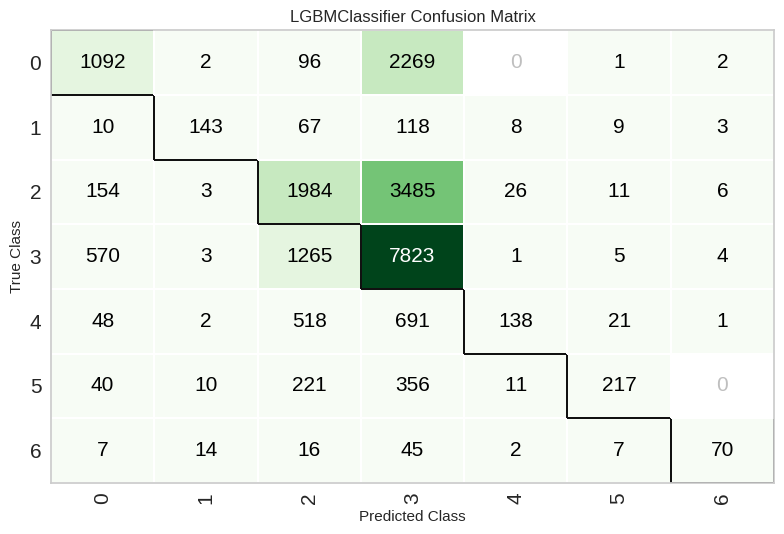

In [ ]:
plot_model(best, plot = 'confusion_matrix')

In [ ]:
save_model(best, 'PermitTime1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['APPLICATION_YEAR',
                                              'EST_CONST_COST'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missi...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='spl

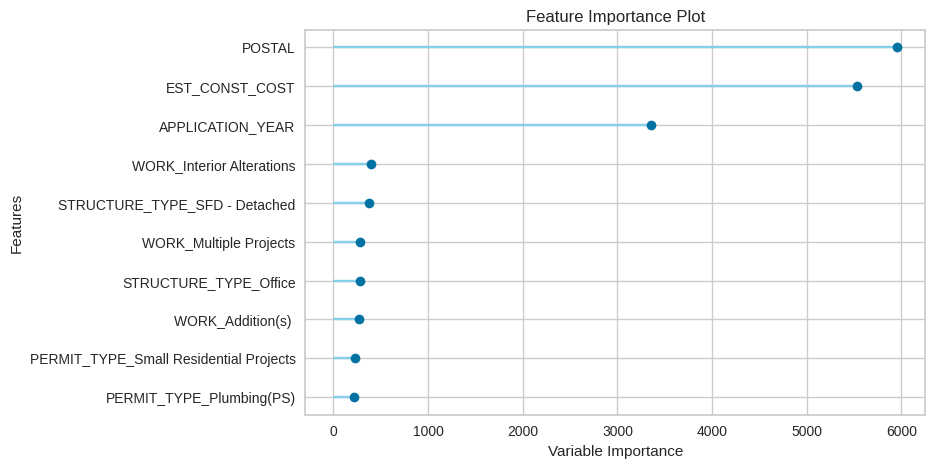

In [ ]:
plot_model(best, plot = 'feature')